# How To Create A Marketing Mix Model With LightweightMMM
The future of advertising attribution is modeled, predicted, estimated, or whatever other word you want.

One of the coolest tools (although still under early development) we have to model the impact of advertising campaigns on revenue is LightweightMMM, an implementation of bayesian marketing mix models developed by Google.

I talked about using this tool with my course sales data and really liked the results. I was surprised by the number of people that are trying to solve the same problem in their companies.

In this article, I will show how to use this tool to build a marketing mix model and find which channels are driving the best ROI for your advertising campaigns.

## Preparing The Data
Instead of using my data, which has very specific patterns due to my niche, I found a cool dataset on Kaggle that has information about different ad groups that were set for brands in a few marketplaces like Walmart.

If you have never run an online ads campaign, they are usually organized by Campaign, Ad Group (or Ad Set), and Ads.

A campaign can have many ad groups that target different groups of people. For example, one ad group can be for people that subscribed to your e-mail list, another for people that visited sites about Python.

Then, inside each ad group, you have the ads that people in that group will see. You can have many ads, with different messages and formats (video vs image).

You never really know which campaign or ad group will be the best before running. It’s normal to launch multiple ad groups and after a few days turn off the ones that are not reaching your goals (like paying too much for someone to install an app).

The problem is that without attribution you don’t know which ad groups to turn off and which to allocate more budget.

With this data and a marketing mix model like LightweightMMM, we can take the data from the ad groups and correlate it to the marketing goal (revenue, installs, leads, etc) and proceed with our optimization (turning off stuff).

To do this, I preprocessed the media data into a format where each row corresponded to a day and each column was the number of impressions for an ad group.

In [1]:
!pip install --upgrade pip
!pip install --upgrade git+https://github.com/google/lightweight_mmm.git
!pip install --upgrade openpyxl

  Cloning https://github.com/google/lightweight_mmm.git to /tmp/pip-req-build-_pc60uk4
  Running command git clone --filter=blob:none --quiet https://github.com/google/lightweight_mmm.git /tmp/pip-req-build-_pc60uk4
  Resolved https://github.com/google/lightweight_mmm.git to commit fa9ce9d09eb5d015ed0f74d08e1b1e5b7c8d01b9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 2.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 3.1.1
    Uninstalling openpyxl-3.1.1:
      Successfully uninstalled openpyxl-3.1.1


In [2]:
import pandas as pd
import numpy as np
from lightweight_mmm import preprocessing, lightweight_mmm, plot, optimize_media
import jax.numpy as jnp
from sklearn.metrics import mean_absolute_percentage_error

/mnt/c/Users/rafael.machado_dp6/Documents/Estudos/lightweight_mmm/tutorial_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-16 11:27:57.688001: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-16 11:28:36.039062: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-16 11:28:36.051355: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open

In [3]:
data = pd.read_excel("content/Sr Advertising Analyst Work Sample (1).xlsx")

agg_data = data.groupby(["Date", "Ad group alias"])[["Impressions","Spend", "Sales",]].sum()
agg_data = agg_data.drop(["Brand 1 Ad Group 12"], axis=0, level=1) # zero cost train

media_data_raw = agg_data['Impressions'].unstack().fillna(0)
costs_raw = agg_data['Spend'].unstack()
sales_raw = agg_data['Sales'].reset_index().groupby("Date").sum()

/tmp/ipykernel_871/3548770463.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sales_raw = agg_data['Sales'].reset_index().groupby("Date").sum()


In [4]:
media_data_raw.head()

Ad group alias,Brand 1 Ad Group 1,Brand 1 Ad Group 10,Brand 1 Ad Group 11,Brand 1 Ad Group 13,Brand 1 Ad Group 2,Brand 1 Ad Group 3,Brand 1 Ad Group 4,Brand 1 Ad Group 5,Brand 1 Ad Group 6,Brand 1 Ad Group 7,Brand 1 Ad Group 8,Brand 1 Ad Group 9,Brand 2 Ad Group 1,Brand 2 Ad Group 2,Brand 2 Ad Group 3,Brand 2 Ad Group 4,Brand 2 Ad Group 5,Brand 1 Ad Group 14,Brand 2 Ad Group 6
Date,,,,,,,,,,,,,,,,,,,
2021-10-17,3317.0,33.0,50966.0,9519.0,40265.0,0.0,142704.0,55.0,94.0,1054.0,248.0,23321.0,276437.0,424883.0,135366.0,41905.0,9871.0,0.0,0.0
2021-10-18,1501.0,30.0,39424.0,14015.0,18545.0,0.0,389663.0,53.0,121.0,1669.0,283.0,28321.0,313907.0,492277.0,119675.0,46550.0,19920.0,50619.0,0.0
2021-10-19,771.0,63.0,236572.0,16543.0,13078.0,0.0,810070.0,58.0,122.0,1795.0,245.0,26105.0,296159.0,475287.0,191075.0,0.0,9253.0,43019.0,0.0
2021-10-20,958.0,70.0,277649.0,24590.0,10743.0,0.0,821705.0,60.0,111.0,948.0,234.0,0.0,314952.0,641517.0,98214.0,61017.0,18669.0,45642.0,0.0
2021-10-21,1841.0,59.0,251202.0,14236.0,10799.0,0.0,1241204.0,72.0,150.0,739.0,394.0,0.0,392621.0,412898.0,88922.0,121214.0,12977.0,69165.0,0.0


Impressions are how many times someone saw at least 50% of an ad. It can be the same person seeing it multiple times.

This is the recommended input data in most of the materials I studied. Probably because it’s a reliable measurement of the campaign delivery.

LightweightMMM uses the spend on a media channel (ad group, in our case) as a prior for the coefficient distribution, so we need to sum the spend for each channel too.

The last thing we need is the target. In our case, it’s the dollar amount of sales each day.

To find how good our model is, I used a simple validation split by time.

I selected the last 28 days as validation, even though they span Christmas time which can break things because our model will not have data from the previous Christmas to understand it’s a high purchase time.

In [5]:
split_point = pd.Timestamp("2021-12-15") # 28 days to end of data

media_data_train = media_data_raw.loc[:split_point - pd.Timedelta(1,'D')]
media_data_test = media_data_raw.loc[split_point:]

target_train = sales_raw.loc[:split_point - pd.Timedelta(1,'D')]
target_test = sales_raw.loc[split_point:]

costs_train = costs_raw.loc[:split_point - pd.Timedelta(1,'D')].sum(axis=0).loc[media_data_train.columns]

Let’s create some simulated organic data so we can see how to take it into account in the model.

In [7]:
organic_raw = pd.DataFrame({'organic_search': 0, 'organic_social': 0}, index=media_data_raw.index)
organic_raw['organic_search'] = sales_raw.values/10 + np.random.random_integers(10000, 100000, organic_raw.shape[0])
organic_raw['organic_social'] = sales_raw.values/10 + np.random.random_integers(10000, 100000, organic_raw.shape[0])

/tmp/ipykernel_871/3372223750.py:2: DeprecationWarning: This function is deprecated. Please call randint(10000, 100000 + 1) instead
  organic_raw['organic_search'] = sales_raw.values/10 + np.random.random_integers(10000, 100000, organic_raw.shape[0])
/tmp/ipykernel_871/3372223750.py:3: DeprecationWarning: This function is deprecated. Please call randint(10000, 100000 + 1) instead
  organic_raw['organic_social'] = sales_raw.values/10 + np.random.random_integers(10000, 100000, organic_raw.shape[0])


Using organic data as extra features can give you a more accurate view of your paid media effects.

## Scaling The Data
LightweightMMM comes with simple-to-use scaler objects. I just followed what was recommended on the original documentation.

This can change if you have a lot of zeros in your data. Then they recommend you scale using only the non-zero values.

We need to scale everything: media data, costs, and the target. Each with a different scaler as usual.

This is important both to get a correct media effect estimate and to help the optimizer when it’s taking steps to find the right coefficients for the model.

In [8]:
organic_data_train = organic_raw.loc[:split_point - pd.Timedelta(1,'D')]
organic_data_test = organic_raw.loc[split_point:]

media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
organic_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train_scaled = media_scaler.fit_transform(media_data_train.values)
organic_data_train_scaled = organic_scaler.fit_transform(organic_data_train.values)
target_train_scaled = target_scaler.fit_transform(target_train.values.squeeze())
costs_scaled = cost_scaler.fit_transform(costs_train.values)

media_data_test_scaled = media_scaler.transform(media_data_test.values)
organic_data_test_scaled = organic_scaler.transform(organic_data_test.values)

media_names = media_data_raw.columns

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Make sure you “squeeze” the target array, as using it with more than a single dimension will raise errors when plotting the results!

## Finding The Right Hyper-Parameters
I care much more about out-of-sample error than in-sample, so I created a simple loop to do a tiny grid search to find the best value for two parameters: the adstock transformation and degrees of seasonality.

Based on my previous experiment, these are the two hyperparameters that make the most difference for this model.

I am completely against grid search for complex machine learning models that have more than 3 hyperparameters. Here each iteration takes 2 minutes and it’s only 9 evaluations, so we can afford it.

The evaluation metric is Mean Absolute Percentage Error (MAPE). It’s easy to interpret and usually a good one for models that forecast sales, like this one.

We can train using GPU or CPU. Every time I tried GPU on this or another dataset, it was much slower than CPU. So I just used CPU.

In [10]:
adstock_models = ["adstock", "hill_adstock", "carryover"]
degrees_season = [1,2,3]

# adstock_models = ["hill_adstock"]
# degrees_season = [1]

mapes = []
hyperparameters = {}
for model_name in adstock_models:
    for degrees in degrees_season:
        mmm = lightweight_mmm.LightweightMMM(model_name=model_name)
        mmm.fit(media=media_data_train_scaled,
                media_prior=costs_scaled,
                target=target_train_scaled,
                extra_features=organic_data_train_scaled,
                number_warmup=1000,
                number_samples=1000,
                number_chains=1,
                degrees_seasonality=degrees,
                weekday_seasonality=True,
                seasonality_frequency=365,
                seed=1)

        prediction = mmm.predict(media=media_data_test_scaled,
                                 extra_features=organic_data_test_scaled,
                                 target_scaler=target_scaler)
        p = prediction.mean(axis=0)

        mape = mean_absolute_percentage_error(target_test.values, p)
        print(f"model_name={model_name} degrees={degrees} MAPE={mape} samples={p[:3]}")

        mapes.append(mape)
        hyperparameters[str(mape)] = {"model_name": model_name, "degrees": degrees}
best_mape = min(mapes)
best_hyperparameters = hyperparameters[str(best_mape)]
print(f"Best MAPE={best_mape} with hyperparameters={best_hyperparameters}")

sample: 100%|██████████| 2000/2000 [01:06<00:00, 30.04it/s, 1023 steps of size 1.87e-03. acc. prob=0.94]


model_name=adstock degrees=1 MAPE=0.07566416199373228 samples=[28455.408 29540.879 29528.727]


sample: 100%|██████████| 2000/2000 [01:10<00:00, 28.29it/s, 668 steps of size 1.64e-04. acc. prob=0.84] 


model_name=adstock degrees=2 MAPE=0.06080670201029825 samples=[24559.67  26533.496 28850.812]


sample: 100%|██████████| 2000/2000 [01:07<00:00, 29.64it/s, 1023 steps of size 2.04e-04. acc. prob=0.59]


model_name=adstock degrees=3 MAPE=0.07346219351675849 samples=[24502.68  26415.78  28673.014]


sample: 100%|██████████| 2000/2000 [00:57<00:00, 34.77it/s, 1023 steps of size 2.84e-03. acc. prob=0.88]


model_name=hill_adstock degrees=1 MAPE=0.1581563644216019 samples=[30678.629 31510.291 32048.104]


sample: 100%|██████████| 2000/2000 [01:15<00:00, 26.58it/s, 1023 steps of size 1.97e-04. acc. prob=0.90]


model_name=hill_adstock degrees=2 MAPE=0.02725846288106033 samples=[24560.605 26495.596 28781.566]


sample: 100%|██████████| 2000/2000 [01:17<00:00, 25.91it/s, 1023 steps of size 2.34e-04. acc. prob=0.80]


model_name=hill_adstock degrees=3 MAPE=0.01970839587896949 samples=[24594.39  26567.525 28854.594]


sample: 100%|██████████| 2000/2000 [07:31<00:00,  4.43it/s, 511 steps of size 7.58e-03. acc. prob=0.91] 


model_name=carryover degrees=1 MAPE=0.16528171551968235 samples=[31011.02  31719.621 32101.986]


sample: 100%|██████████| 2000/2000 [12:11<00:00,  2.73it/s, 1023 steps of size 5.70e-04. acc. prob=0.56]


model_name=carryover degrees=2 MAPE=0.6710726301143314 samples=[24110.564 25127.707 26183.023]


sample: 100%|██████████| 2000/2000 [14:47<00:00,  2.25it/s, 1023 steps of size 2.45e-04. acc. prob=0.91]


model_name=carryover degrees=3 MAPE=0.058179466533277005 samples=[24303.89  25965.887 28020.203]
Best MAPE=0.01970839587896949 with hyperparameters={'model_name': 'hill_adstock', 'degrees': 3}


In [11]:
hyperparameters = sorted(hyperparameters.items())
print(f"Hyperparameters by order of best MAPEs:\n{hyperparameters}")

Hyperparameters by order of best MAPEs:
[('0.01970839587896949', {'model_name': 'hill_adstock', 'degrees': 3}), ('0.02725846288106033', {'model_name': 'hill_adstock', 'degrees': 2}), ('0.058179466533277005', {'model_name': 'carryover', 'degrees': 3}), ('0.06080670201029825', {'model_name': 'adstock', 'degrees': 2}), ('0.07346219351675849', {'model_name': 'adstock', 'degrees': 3}), ('0.07566416199373228', {'model_name': 'adstock', 'degrees': 1}), ('0.1581563644216019', {'model_name': 'hill_adstock', 'degrees': 1}), ('0.16528171551968235', {'model_name': 'carryover', 'degrees': 1}), ('0.6710726301143314', {'model_name': 'carryover', 'degrees': 2})]


The `predict` method outputs the samples for each chain. To get a point estimate, we take the mean of the samples.

This model can be used with weekly data too, so to use it with daily data we need to use the `weekday_seasonality` parameter and adjust the `seasonality_frequency` parameter to capture the seasonality effects correctly.

## Retraining LightweightMMM
After finding the best combination of hyperparameters we retrain the model, now using all the data.

Just like in the other model, `carryover` adstock and `seasonality degrees = 1` was the best combination. But it takes 20+ minutes to run on Colab, so I settled for `hill_adstock` which is not much worse but runs in 2 minutes. 
(Not in my own implementation, though. The best hyperparameters for my own implementation are `hill_adstock` and `seasonality degrees = 3`. So I will use that to train the model.)

Online ads campaign data changes very quickly, so I would recommend retraining your model daily to always be working with the freshest patterns.

One additional experiment I would do if I had more data would be to find the best window size to train. For example: is it better if I use the last 3, 6, or 12 months of data to train my model?

There is no way of knowing without trying and seeing which gives you the best error. Just like I explained in the [zero-inflated marketing mix model](https://forecastegy.com/posts/daily-marketing-mix-model/) article.

In [12]:
costs = costs_raw.sum(axis=0).loc[media_names]

media_scaler2 = preprocessing.CustomScaler(divide_operation=jnp.mean)
organic_scaler2 = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler2 = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler2 = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_scaled = media_scaler2.fit_transform(media_data_raw.values)
organic_data_scaled = organic_scaler2.fit_transform(organic_raw.values)
target_scaled = target_scaler2.fit_transform(sales_raw.values)
costs_scaled2 = cost_scaler2.fit_transform(costs.values)

media_names = media_data_raw.columns

mmm = lightweight_mmm.LightweightMMM(model_name=best_hyperparameters["model_name"]) # "hill_adstock"
mmm.fit(media=media_data_scaled,
        media_prior=costs_scaled2,
        extra_features=organic_data_scaled,
        target=target_scaled,
        number_warmup=1000,
        number_samples=1000,
        number_chains=1,
        degrees_seasonality=best_hyperparameters["degrees"], # 3
        weekday_seasonality=True,
        seasonality_frequency=365,
        seed=1)

sample: 100%|██████████| 2000/2000 [02:00<00:00, 16.54it/s, 1023 steps of size 7.91e-04. acc. prob=0.91]


## Plotting LightweightMMM
LightweightMMM offers a multitude of plots that you can add to reports and presentations.

The two I like most are the media effects and the ROI plots.

The media effects plot shows an estimate of the coefficients for each media channel. High numbers mean the channel influenced the revenue more.

The x-axis is the estimated coefficient, the y-axis can be seen as how confident the model is that the x-axis value is the right value for the media effect.

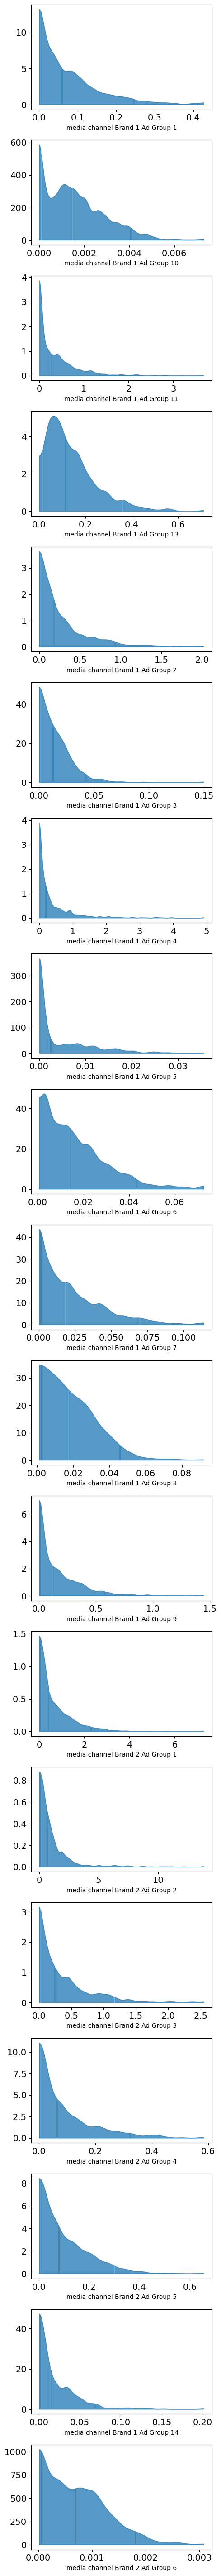

In [13]:
plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names=media_names)

In the example above, the model thinks the effect for this channel is likely zero, but it’s not completely confident, so it extends its confidence to an area mostly between 0 and 0.02.

But only knowing the effect is limited, as a channel can be very effective but very expensive. So we have the ROI plot.

This plot takes into account not only the media effect but how much it costs to get this effect. The rule of thumb would be to allocate more budget to high ROI channels and less to low ROI ones.

This is not always possible, as a channel can have very good ROI but not be scalable.

Retargeting is an example: it’s very easy to get a good ROI when advertising for people that already know your product, but it’s a very limited group.

In [28]:
roi_hat = mmm.get_posterior_metrics(cost_scaler=cost_scaler2, 
                          target_scaler=target_scaler2)[1]
roi_hat

Array([[127.88566 , 107.23051 ,  22.122839, ...,  78.39123 ,  69.19417 ,
         21.652063],
       [ 85.565155,  50.142963,  62.106766, ...,  16.412325,  18.376078,
         26.90862 ],
       [ 83.662796,  51.24501 ,  58.78531 , ...,  23.146767,  11.322343,
         30.93598 ],
       ...,
       [ 44.320057,  60.205494,  78.243614, ...,  20.24281 ,  62.249577,
        123.29175 ],
       [ 62.46623 ,  53.607586,  62.299614, ...,  26.090008,  58.86524 ,
         70.09654 ],
       [ 28.185831,  69.67317 ,  73.39214 , ...,  29.739052,  65.89522 ,
         64.67804 ]], dtype=float32)

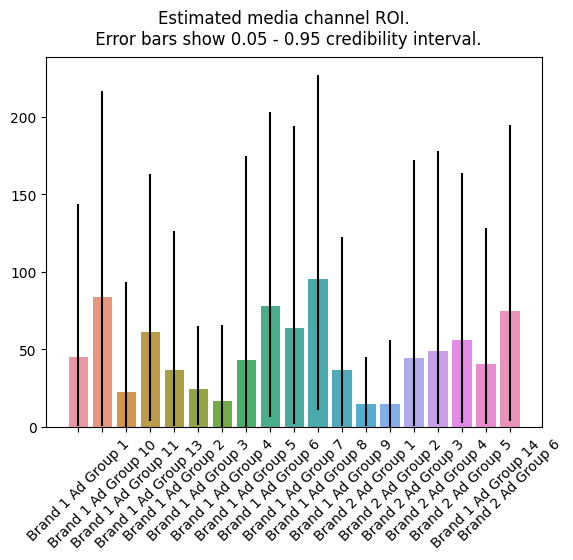

In [29]:
plot.plot_bars_media_metrics(metric=roi_hat, 
                             metric_name="ROI",
                             channel_names=media_names)

In practice, I used it as additional information to turn off ad groups and audiences that weren’t performing.

An additional tip: to run the plots in Colab, we need to install matplotlib version 3.1.3:

In [ ]:
# !pip uninstall -y matplotlib
# !pip install matplotlib==3.1.3

## LightweightMMM Budget Optimizer
The library offers a budget optimizer. It’s still not very clear to me how to use this tool. It takes a long time but can give you exact numbers to allocate to channels.

In [47]:
prices = costs / media_data_raw.sum(axis=0)
budget = 1.1 # your budget here
solution = optimize_media.find_optimal_budgets(n_time_periods=10,
                                               media_mix_model=mmm,
                                               extra_features=organic_data_scaled[-10:, :],
                                               budget=budget,
                                               prices=prices.values)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.942140989482212
            Iterations: 32
            Function evaluations: 1248
            Gradient evaluations: 32


In [50]:
solution

( message: Optimization terminated successfully
  success: True
   status: 0
      fun: -9.942140989482212
        x: [ 8.000e+00  8.000e+00 ...  8.000e+00  8.000e+00]
      nit: 32
      jac: [-2.772e-03 -1.637e-04 ... -8.764e-04 -9.629e-05]
     nfev: 1248
     njev: 32,
 Array(-9.86889154, dtype=float64),
 Array([8.06823873, 8.06823873, 8.06823873, 8.06823873, 8.06823873,
        8.06823873, 8.06823873, 8.06823873, 8.06823873, 8.06823873,
        8.0682395 , 8.06823873, 8.0682395 , 8.06823873, 8.06823873,
        8.06823873, 8.06823873, 8.06823873, 8.0682395 ], dtype=float64))

`prices` is an array with the cost per impression for each media channel. I just took the historical cost.

The optimizer returns a tuple with 3 items. The third item (`solution[3]`) is the budget allocation.

As the ad buyer, I feel more comfortable taking the results of the model as guidance than using the exact numbers suggested by the optimizer.

Note that for this to work well, you would need to specify the organic impressions you expect to have in the future optimization period.

One way to do it is by simply considering the future will be like the most recent past (use the last N time periods of organic data as extra features).

As always, double-check your assumptions to make sure they are not too optimistic.

## Expanding the Data with Geos
Since the last time I used the model, the developers added the option to use data at a more granular level, which is extremely valuable for these models.

The example in the documentation talks about using state-level data instead of aggregating at a national level when modeling ads in a large country like the United States.

This allows us to have more rows and get more accurate coefficients in our model.

Here we have data from 3 different marketplaces, so I wanted to see if treating each one as a different “geo” worked too.

This can be done by adding a dimension to the original data. So our input array will have dimensions `(days, channels, geos)`.

In [62]:
agg_data = data.groupby(["Date", "Ad group alias", "Marketplace"])[["Impressions","Spend", "Sales",]].sum()
agg_data = agg_data.drop(["Brand 1 Ad Group 12"], axis=0, level=1) # zero cost train

media_data_raw_ = agg_data['Impressions'].unstack(level=1).fillna(1) # scaler goes crazy if fillna = 0 because of division by zero
sales_raw_ = agg_data['Sales'].reset_index().groupby(["Date", "Marketplace"]).sum()
costs_raw = data.groupby(["Date", "Ad group alias"])[["Spend"]].sum().drop(["Brand 1 Ad Group 12"], axis=0, level=1).unstack()

media_concat = list()
sales_concat = list()
for marketplace in ["Amazon", "Ebay", "Walmart"]:
    df_ = media_data_raw_.loc[(media_data_raw_.index.get_level_values(0), marketplace), :].values
    df_ = np.expand_dims(df_, 2)
    media_concat.append(df_)

    sdf_ = sales_raw_.loc[(sales_raw_.index.get_level_values(0), marketplace), :].values
    #sdf_ = np.expand_dims(sdf_, 1)
    sales_concat.append(sdf_)

media_data_raw = np.concatenate(media_concat, axis=2)
sales_raw = np.concatenate(sales_concat, axis=1)

split_point = -28

media_data_train = media_data_raw[:split_point, :, :]
media_data_test = media_data_raw[split_point:, :, :]

target_train = sales_raw[:split_point, :]
target_test = sales_raw[split_point:, :]

media_names = media_data_raw_.columns

costs_train = costs_raw.iloc[:split_point].sum(axis=0)

media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train_scaled = media_scaler.fit_transform(media_data_train)
target_train_scaled = target_scaler.fit_transform(target_train.squeeze())
costs_scaled = cost_scaler.fit_transform(costs_train.values)

media_data_test_scaled = media_scaler.transform(media_data_test)

/tmp/ipykernel_871/736068389.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sales_raw_ = agg_data['Sales'].reset_index().groupby(["Date", "Marketplace"]).sum()


I had to fill the NaNs with 1 impression in the input data for the scaler and model to work. This should not throw off the model as we have many more legitimate impressions than NaNs.

The rest of the code is basically the same, but now we get a prediction for each day and geo instead of the aggregated target.

MAPE was slightly better as expected.

There are many ways we can slice this data to get more rows, but this is a topic for another article.

## Extra Features
One capability I didn’t use here but can be very useful is that you can add extra features to your model beyond organic impressions data.

Suppose you ran a promotion for a week. You can create extra features indicating the days of the promotion so the model can better capture its effect.

## LightweightMMM Is Promising
I really like this project and think it has a very bright future, this is why I decided to write a more in-depth, code-heavy, article about it.

At this moment I am not selling anything, so not buying ads, but when I run campaigns again I will definitely keep an updated model to help me optimize my budget.

I recently ran an experiment with it on Instagram and got a lesson about multicollinearity.

Happy modeling!